In [13]:
# Add the parent directory to sys.path
import sys, os
from pathlib import Path

current_directory = os.getcwd()
parent_directory = Path(current_directory).parent.parent
sys.path.insert(0, str(parent_directory))
sys.path

['c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv',
 '',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\Pythonwin']

# Connect to database

In [2]:
# Import the utils moudle
from scripts import utils

In [3]:
# Load the credentialsand connect to database
CREDENTIALS  = utils.load_environment_variables(parent_directory=parent_directory)
connection = utils.connect_to_database({"dbname": CREDENTIALS['DB_NAME'],
                                 "user": CREDENTIALS['USER'],
                                 "host": CREDENTIALS['host'],
                                 "port": CREDENTIALS['port']})

INFO:scripts.utils:Trying to load environment variables from c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis/.env
INFO:scripts.utils:Credentials loaded successfully
INFO:scripts.utils:Attempting to connect to the database
INFO:scripts.utils:Connection successful


In [4]:
# Load the db files into pandas dataframe and close the connection
table_name = 'xdr_data'
df = utils.load_data_from_db(conn=connection,
                       table_name=table_name)
utils.close_database_connection(conn=connection)

INFO:root:Executing query: SELECT * FROM xdr_data
c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis\scripts\utils.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
INFO:scripts.utils:Data loaded into DataFrame successfully
INFO:root:Database connection closed successfully


### Data preparation and cleaning

##### Handle missing values and outliers for relevant columns

In [5]:
# Import the MissingValueHandler class and create an instance
from scripts.data_processing import MissingValueHandler

relevant_columns = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)',
                    'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
                    'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
                    'Handset Type']
missing_value_handler = MissingValueHandler(df=df[relevant_columns])

INFO:root:MissingValueHandler instance created


In [6]:
summary = missing_value_handler.missing_value_summary()
summary

INFO:root:Missing value summary computed successfully


Avg RTT DL (ms)                27829
Avg RTT UL (ms)                27812
Avg Bearer TP DL (kbps)            1
Avg Bearer TP UL (kbps)            1
TCP DL Retrans. Vol (Bytes)    88146
TCP UL Retrans. Vol (Bytes)    96649
Handset Type                     572
dtype: int64

In [7]:
percentage = missing_value_handler.missing_value_percentage()
percentage

INFO:root:Missing value percentage computed successfully


Avg RTT DL (ms)                18.552543
Avg RTT UL (ms)                18.541210
Avg Bearer TP DL (kbps)         0.000667
Avg Bearer TP UL (kbps)         0.000667
TCP DL Retrans. Vol (Bytes)    58.763608
TCP UL Retrans. Vol (Bytes)    64.432237
Handset Type                    0.381331
dtype: float64

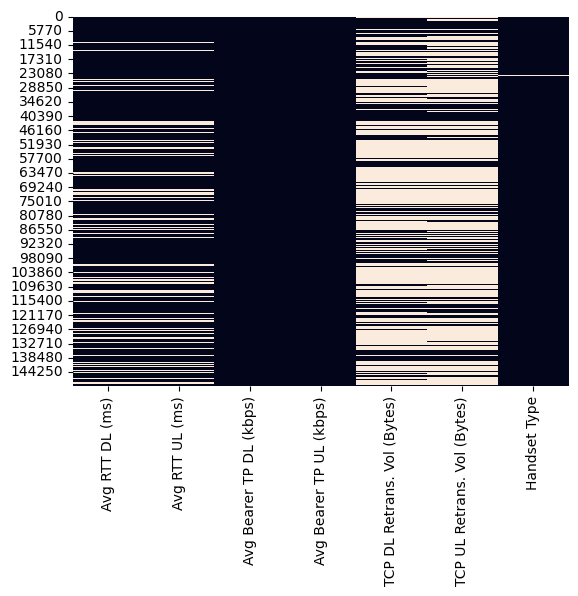

INFO:root:Missing values heatmap displayed successfully


In [8]:
missing_value_handler.missing_values_heatmap()

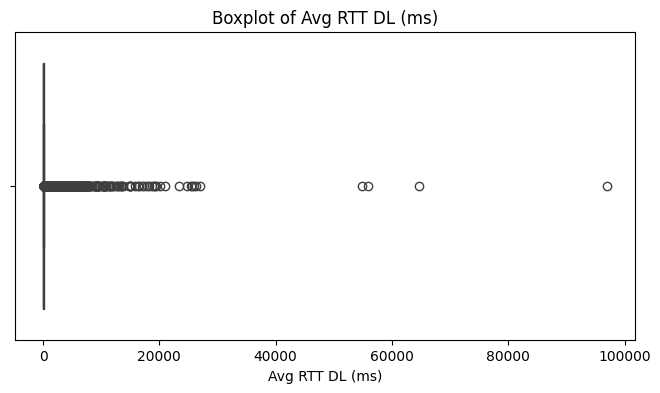

INFO:root:Boxplot for column 'Avg RTT DL (ms)' displayed successfully


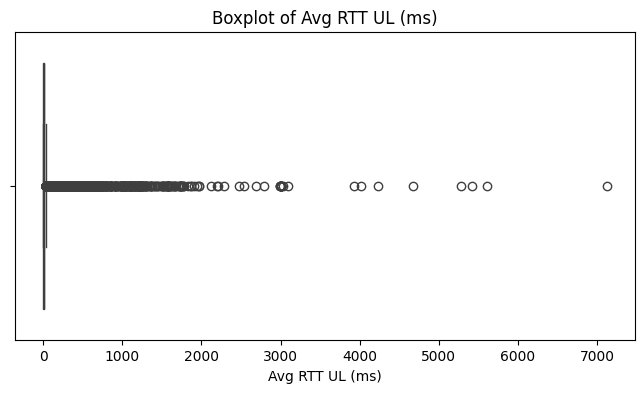

INFO:root:Boxplot for column 'Avg RTT UL (ms)' displayed successfully


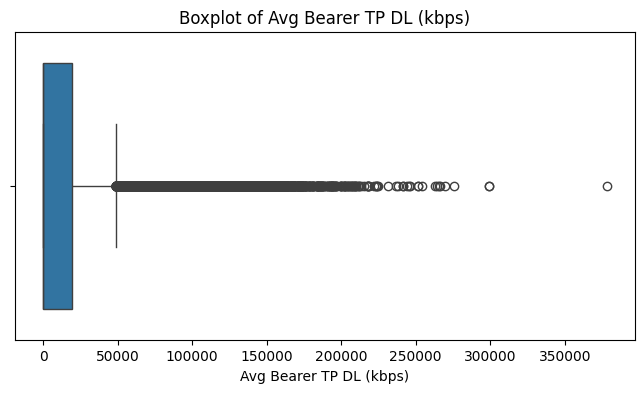

INFO:root:Boxplot for column 'Avg Bearer TP DL (kbps)' displayed successfully


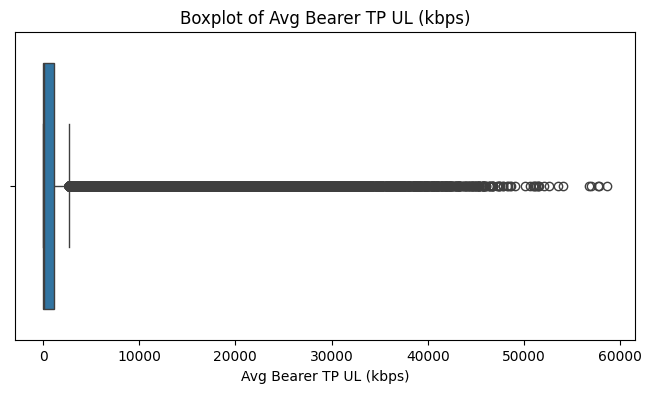

INFO:root:Boxplot for column 'Avg Bearer TP UL (kbps)' displayed successfully


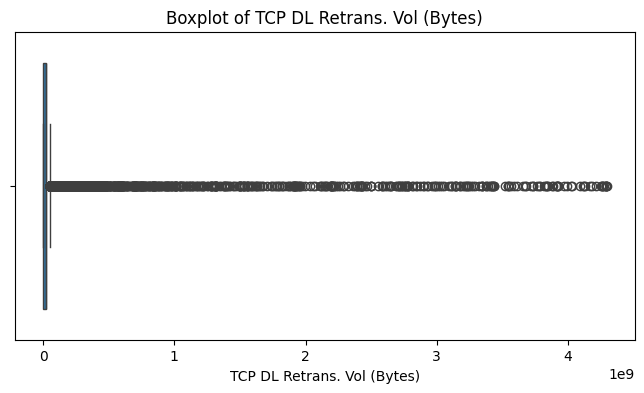

INFO:root:Boxplot for column 'TCP DL Retrans. Vol (Bytes)' displayed successfully


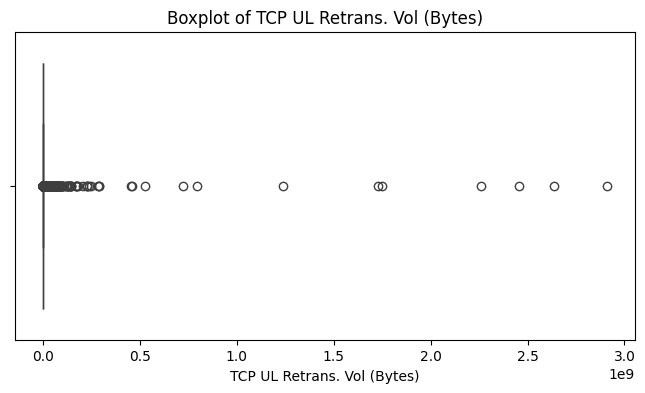

INFO:root:Boxplot for column 'TCP UL Retrans. Vol (Bytes)' displayed successfully


In [25]:
missing_value_handler.inspect_outliers()

- The Handset Type and Throughput data seems to have almost complete dataset but the RTT and TCP retransmission columns exhibit significant missing data.
- Also the dataset have significant number of outliers, so first I will replace outliers with appropriate values and I will handle missing values.

- I'll use the **Tukey's Fences** method to detect and replace outliers and in the dataset.

In [46]:
from scripts import experience_utils

modified_df = experience_utils.tukeys_fence(df=df,
                                            columns=relevant_columns[:-1])

INFO:root:Q1, Q3, and IQR calculated successfully
INFO:root:Lower bound and upper bound calculated successfully
INFO:root:Tukey's Fence applied successfully


INFO:root:MissingValueHandler instance created


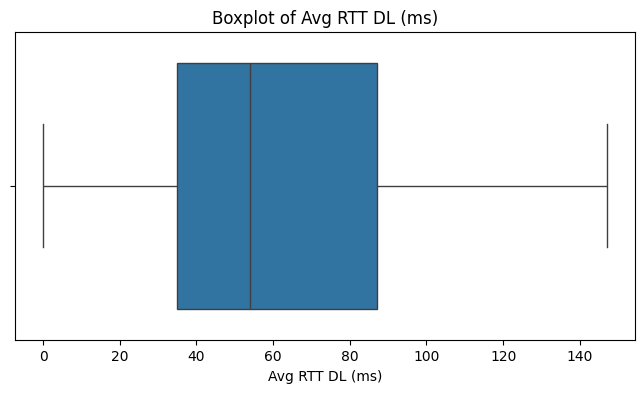

INFO:root:Boxplot for column 'Avg RTT DL (ms)' displayed successfully


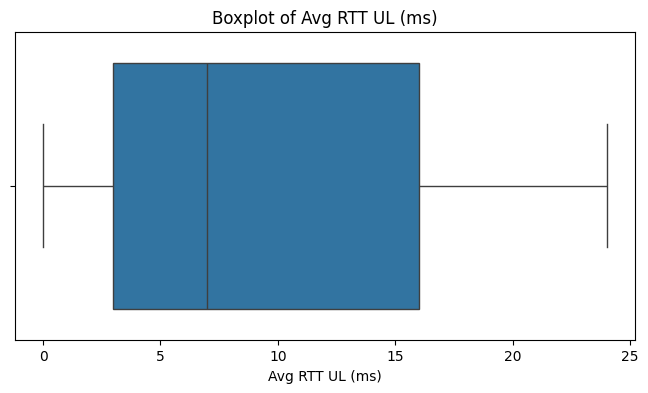

INFO:root:Boxplot for column 'Avg RTT UL (ms)' displayed successfully


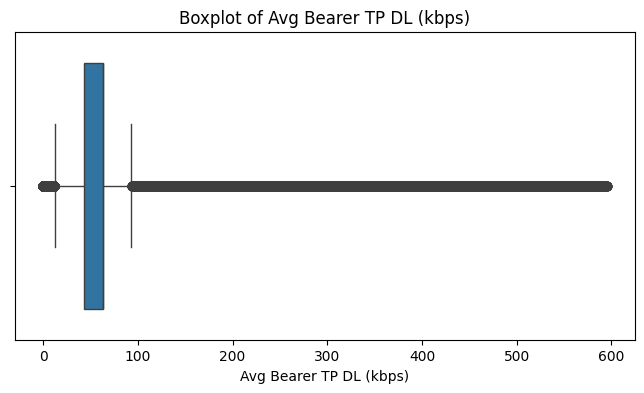

INFO:root:Boxplot for column 'Avg Bearer TP DL (kbps)' displayed successfully


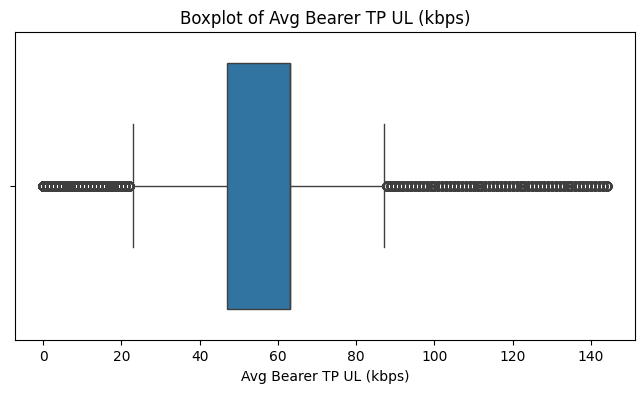

INFO:root:Boxplot for column 'Avg Bearer TP UL (kbps)' displayed successfully


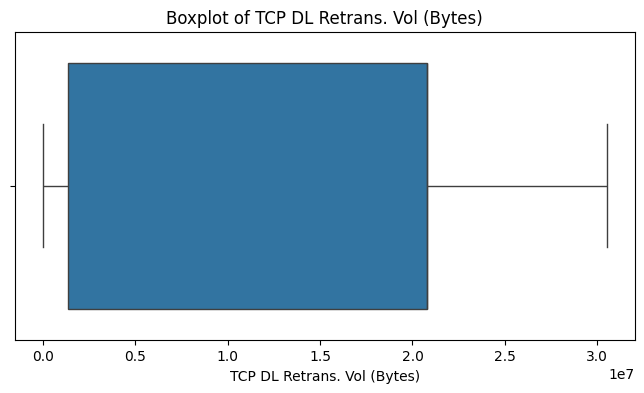

INFO:root:Boxplot for column 'TCP DL Retrans. Vol (Bytes)' displayed successfully


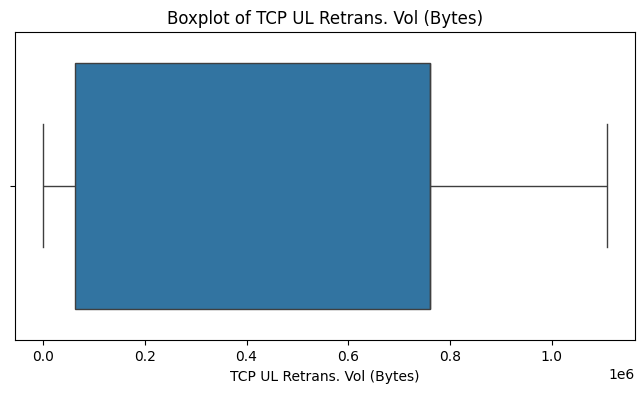

INFO:root:Boxplot for column 'TCP UL Retrans. Vol (Bytes)' displayed successfully


In [48]:
# Inspect outlier to check correction
missing_value_handler = MissingValueHandler(modified_df[relevant_columns])
missing_value_handler.inspect_outliers()

- Now I will replace numerical columns with means

In [81]:
# Fill missing numerical values with the mean
for column in relevant_columns[:-1]:
    modified_df[column].fillna(modified_df[column].mean())

# Fill missing Handset Type with the mode
modified_df['Handset Type'].fillna(modified_df['Handset Type'].mode()[0])
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [82]:
# Inspect the new data frame
missing_value_handler = MissingValueHandler(modified_df[relevant_columns])
missing_value_handler.missing_value_summary()

INFO:root:MissingValueHandler instance created
INFO:root:Missing value summary computed successfully


Avg RTT DL (ms)                0
Avg RTT UL (ms)                0
Avg Bearer TP DL (kbps)        0
Avg Bearer TP UL (kbps)        0
TCP DL Retrans. Vol (Bytes)    0
TCP UL Retrans. Vol (Bytes)    0
Handset Type                   0
dtype: int64

- We can see that missing values have been replaced correctly

### Data Aggregation

In [83]:
# Aggregate relevant columns per user
aggregation_methods = {
    'Avg RTT DL (ms)': 'sum', 
    'Avg RTT UL (ms)': 'sum',
    'Avg Bearer TP DL (kbps)': 'sum', 
    'Avg Bearer TP UL (kbps)': 'sum',
    'TCP DL Retrans. Vol (Bytes)': 'sum', 
    'TCP UL Retrans. Vol (Bytes)': 'sum',
    'Handset Type': lambda x: x.mode()[0] #  Most frequent Handset Type per customer
}
relevant_df = modified_df.groupby('MSISDN/Number').agg(aggregation_methods).reset_index()
relevant_df.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Handset Type
0,3.360100e+10,46.000000,0.000000,37.0,39.0,2.080991e+07,759658.664811,Huawei P20 Lite Huawei Nova 3E
1,3.360100e+10,30.000000,1.000000,48.0,51.0,2.080991e+07,759658.664811,Apple iPhone 7 (A1778)
2,3.360100e+10,109.795706,17.662883,48.0,49.0,2.080991e+07,759658.664811,undefined
3,3.360101e+10,69.000000,15.000000,204.0,44.0,1.066000e+03,759658.664811,Apple iPhone 5S (A1457)
4,3.360101e+10,114.000000,5.000000,86.0,103.0,3.015954e+07,780860.664811,Apple iPhone Se (A1723)


### Top 10, Bottom 10 and 10 Most frequent values

In [89]:
# List of columns for analysis
metrics = ['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 
           'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 
           'Avg RTT DL (ms)', 'Avg RTT UL (ms)']

# Top Values
top_values = relevant_df[metrics].sort_values(by=metrics, ascending=False).head(10)

# Bottom Values
bottom_values = relevant_df[metrics].sort_values(by=metrics, ascending=True).head(10)

##### Top Values

In [93]:
top_values

,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Avg RTT DL (ms),Avg RTT UL (ms)
13180,2.500190e+08,1.216393e+07,2145.0,1017.0,645.795706,89.662883
92923,2.424158e+08,7.790941e+06,684.0,805.0,1397.957061,221.628829
13526,2.292513e+08,7.598760e+06,893.0,1027.0,1143.365648,171.303063
70960,2.187004e+08,7.601644e+06,259.0,204.0,624.591412,92.325766
106137,1.875289e+08,8.356360e+06,922.0,497.0,877.569942,147.640180
13994,1.872988e+08,4.569922e+06,679.0,694.0,984.978530,104.314415
57160,1.872892e+08,6.836928e+06,248.0,493.0,988.161354,158.965946
76657,1.872892e+08,6.077517e+06,1743.0,538.0,522.387118,66.988649
1648,1.664794e+08,6.836928e+06,1151.0,579.0,450.591412,57.325766
76363,1.600032e+08,7.349955e+06,806.0,846.0,979.000000,83.000000


##### Bottom Values

In [96]:
bottom_values

,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Avg RTT DL (ms),Avg RTT UL (ms)
56622,2.0,21557.000000,12.0,63.0,54.0,4.0
95322,2.0,759658.664811,12.0,63.0,28.0,4.0
95331,4.0,1318.000000,6.0,60.0,63.0,1.0
71778,4.0,5296.000000,13.0,63.0,35.0,2.0
100663,4.0,77762.000000,15.0,63.0,21.0,2.0
100616,4.0,95464.000000,11.0,63.0,28.0,18.0
87156,4.0,759658.664811,7.0,55.0,54.0,2.0
95774,4.0,759658.664811,9.0,63.0,47.0,7.0
95213,4.0,759658.664811,11.0,63.0,40.0,4.0
87348,4.0,759658.664811,16.0,143.0,37.0,8.0


##### Most frequent values

In [97]:
for metric in metrics:
    print(f"\nTop 10 most frequent values for {metric}:\n")
    print(df[metric].value_counts().head(10))


Top 10 most frequent values for TCP DL Retrans. Vol (Bytes):

TCP DL Retrans. Vol (Bytes)
2.080991e+07    91901
1.330000e+03      433
2.660000e+03      219
3.800000e+01      200
9.200000e+01      192
1.318000e+03      156
5.430000e+02      133
3.990000e+03      114
7.600000e+01      108
5.320000e+03      102
Name: count, dtype: int64

Top 10 most frequent values for TCP UL Retrans. Vol (Bytes):

TCP UL Retrans. Vol (Bytes)
759658.664811    98640
1330.000000       1910
2660.000000        937
1294.000000        651
3990.000000        548
1318.000000        545
5320.000000        366
6650.000000        271
2636.000000        234
7980.000000        219
Name: count, dtype: int64

Top 10 most frequent values for Avg Bearer TP DL (kbps):

Avg Bearer TP DL (kbps)
63.0    64285
23.0     7324
43.0     4352
44.0     4186
6.0      3983
22.0     2867
48.0     2778
42.0     2689
45.0     2644
47.0     2263
Name: count, dtype: int64

Top 10 most frequent values for Avg Bearer TP UL (kbps):

Avg Bear